<a href="https://colab.research.google.com/github/patriciamedyna/Digit_Classifier/blob/master/train_fastai_without_tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import pickle

import matplotlib.cm as cm

from fastai import *
from fastai.text import *
from IPython.display import display,HTML


from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [5]:
bs=64

## Loading Data

In [6]:
path = '/content/gdrive/MyDrive/Colab Notebooks/Tobacco_LSTM/layout/'

In [7]:
df = pd.read_csv(path + 'df_train.csv', delimiter=',', error_bad_lines=False)

In [8]:
df

,class,text,is_valid
0,FirstPage,"Dr. M.A. Manzelli, PHILIP MORRIS INC., Research Center, P.O. Box 3 D Richmond, Va. 23206 U.S.A. Dear Art, Please find enclosed a proposed program for your visit in Europe. As you will see, this program contains two major points: a) A two-days meeting in Neuchätel with all people in Europe involved in infestation control (proposed program included). b) Visit of all PM Europe production centers with the purpose of: - training people in Charge of the insect indenti-fication - inspection of the sanitary conditions One of our main problems is the insect Identification and ...",False
1,NextPage,"- 2 - Please let me krow if you have any changes for the proposed program. Looking forward to seeing you again, cc: Messrs. B. Kuhn E. Stoop Encl.: mentioned 1000035625",False
2,FirstPage,"I NOIJ-04-97 13 = 25 FROM = I D : PAGE 10/17 Wachtell, Lipton, Rosen & Katz MARTIN L1PTON HERBERT M. WaCHYCLL THEODORE GEWSRTZ »ERNA*» W, NUSSBAUM RICHARD O- HATCHER DOUGLAS Sr LieBKAfSKV STEVEN M. SAR NA CMARt.CS T. MEPCRR'GK CHAIN J. FOPTCANG pBTRR C. 1AMCLLDS MICHAEL w. SCHWÄRT* Al.LAR A- MARTIN BARRV A. BRrCR IAWREHCE □. PEDQrWITZ ROBERT 0. MAZUR PAUL VIZGARRÖMSCK JR. PCTCR G- HCIM hAROlD s. «OViKOFF DAVID M. EINHORN KENNET« B. FQRREST METER C. KOPLOW THEODORE M- MIRVIS EDWARD D. MERL1HT RICHARD D. FEINTUCH DANIEL A. NEPP ERIC M. ROTR WAHREN R. STERN ANDREW R. BROWN ST EIN MICHAEL H...",False
3,FirstPage,"i PHILIP .MORRIS INCORPORATED 120 PARK AVENUE, N EW YORK. N. Y. 10017 John T.-Landhy SENIOR VICC PRESIDENT _ , r . n n - . oirector of Marketing February 15, 19 83 Dear Ms. Ober: Your letter of February 3 was received by this Office yesterday. We attempted to reach you by telephone iinmediately but were unable to find a listed number in New Haven. I had hoped to arrange an appointment for one of our executives to discuss with you and your concerned ...",False
4,NextPage,"In the meantime, I hope you and your friends are continuing to enjoy your Marlboro Lights ciga-rettes. We don't think you can find a better"" cigarette on the market. ■Thank you. Ms. Angela Ober 221 Farnham Avenue New Haven, Connecticut 06515",False
...,...,...,...
1026,NextPage,"«AR 18 »Sg 14t99 FROM B/W LAU DEPT PAGE.Q03 P*fl® t Maroh 18, 1992 Letter fco K. fii yeeterday 1» which American would represent that it does not m)w any itlai of the wcxt STRIKs «ad fall mall producta in the United States, inoiuding tu® U.S. duty free narbet# fot re-oacpott to »ttd resale in any country where Brom * wlllieason# or a mamber of the b.a.t. Group of 0Oa&anies, has registered theso tradomarks# and that any sudü aale by any parson woUld be oonaidered an infringement of Brown & Williamson*® tredemark rights. 4 3* Pr...",False
1027,FirstPage,"MOV 2 11994 Si iook.J Iakdyü. Bacon November 18, 1994 FEDERAL EXPRESS TO: ETS/IAQ Current Developments Report Distribution Enclosed you will find a copy of the most recent issue of the ETS/XACl Current Developments Report. If you have questions or information rega.rd.ing items contained in this Report, please feel free to contact either of us at (816) 4*74-6550. Sincerely MWC : KAM : lew Enclosure cc: Report: Team 88325694",False
1028,FirstPage,"THE TOBACCO INSTITUTE, inc. ■1776 K STREET, NORTHWEST! WASHINGTON, D.C. 2000b i 202.'296-8434 HORACE R. KORNEGAY President May 13, 1975 Mr. Colin Stokes Chairman of the Board of Directors R. J. Reynolds Industries, Inc. 401 North Main Street Winston-Salem, North Carolina 27102 Dear Colin: The terms on which your and other Companies agreed to participate in the establishment and Operation of the Tobacco Institute Testing Laboratory (T.I.T.L.) were set förth in the Institute letter of November 1, 1966, which was accepted by each participating Company. Based on recent discussions which I ha...",False
1029,NextPage,"two billion units. Each Company responsible for additional expenses shall be assessed for the per-centage of such additional expenses as is determined by using that Company's to

In [9]:
#df_train = df[df["is_valid"] == False]; df_train
#df_test = df[df["is_valid"] == True]; df_test


In [10]:
df_test = pd.read_csv(path + 'df_test.csv', delimiter=',', error_bad_lines=False)

In [11]:
df_test

,class,text,is_valid
0,FirstPage,"rii.E ^litl' karg;; , 1980 ■'!?.!r- ■ !T |Sf: .'■■ J -1 p '■Mr'"" trr*. my MAILLARD REACTION ""A"" FLAVOR COMPONENTS./ A ] 5 6 *! •• f ----------------------------------------- ! i f i wii'.ii ■. , . j i i F; tp...' t/ t-■ l. ■i. v.' i -!* .i■ uill .,0'; [o,.' ' ’. Identification of flavor components in the ütjiieous la...",True
1,NextPage,FIGURE I GAS CHROMATOGRAF!,True
2,NextPage,"TABLE 1 Subfraction Ho. Gdc]~ T r a n s i t i o n During H_lnt j_wn 1 Floral 2 Mi.lk chocolate, sweet 3 Cocoa, floral 4 ChocoJatc , weak cocoa. strong cocoa 5 Sweet cocoa, sweet fruity, cooked fruity, green itasty 6 Green and chocolate, faint cocoa, sweet, sharp green, green bell pepper, sweet nutty, burnt bready nutty, bready sweet, sweet green 7 Green pepper, sharp ranci...",True
3,NextPage,"Tab u 1 J Subfraction // 3 8 Components Identified Re 1 . Abnndai 2-mettiy 1 pro p anal 3-methylbutanal 2-methylbutanal 2-hexero 1-isocyanatopropane 2,5-dimethylfuran 2-methyl-N - (2-methylpropylidcne)-1-propanainine cyclohexane 2,3-pentandione pyrazine 3-penten-2-one pyridine phenol cyclopentanone 4-me thyl-2-hexene methyIcyclobexane 2-jmethylpy r idine cyclohexanone meLhylphenol 2-methyl-N-(2-methy1propylidene)-1-propanamine ethylbenzene 2-piperidine methatieamine 1-hydroxy-2-propancne 2-methyl-l-pentcne methylpyrazine ethenylbenzem- 2,5-dimethyl pyrazine 2-imitlo-cy c lnpentane o...",True
4,NextPage,Talj.lt’ IT Subfraction ii Components Identified Re] . Abundance 7 tyclohexane ++ 2.2-dinethyl-hexanf' + oxi ran eite thanol + *cyclopentene ++ 2-methy1-2-cycT openten-l-onc + l-(2-furanyl)-ethanone ++ furan...,True
...,...,...,...
254,NextPage,"Hr. Patrick Leathem Page Two November 14, 1990 When corresponding with this office, please include your claim number and the claimant*s ziame. Very truly yours PHILIP MORRIS MANAGEMENT CORP. Ellen Dimech Claims Coordinator cc: David Curie Sue Strausser Colleen Flinn Cläre Pureeil 2063270105",True
255,FirstPage,"LAW OFFICES OF NIELSEN, MERKSAMER, HODGSON, PARRINELLO & MUELLER 770 L STREET, SUITE 800 SACRAMENTO, CALIFORNIA 05814 TELEPHONE (916) 4*6-6752 SACRAMENTO A PARTNERSHIP INCLUD1NG A PROFESSIONAL CORPORATION 591 REDWOOD HIGHWAY, #4000 MILL VALLEY, CALIFORNIA 94941 TELEPHONE (413) 369-6S00 650 CALIFORNIA STREET SUITE 2650 SAN FRANCI5CO, CALIFORNIA 94108 TELEPHONE (415) 989-6800 ...",True
256,FirstPage,"/ Wachtell, Ljpton, Rosen & Katz WABTIN UFTON HERBERT M. WACMTCU TH£OBOR£ BEWERT* S£ft*t*3?G W. NUSSBAUM RiCHA.RD O- .HAT CH ER UGUGtAS S, UEBHAF5XY STEVEN M. 0ARWA CH AI« J, FORTGANG PETEJ5 C, GANELLÜS MiCHA^L W. SCHWAftTZ AiLAM A, MABT)H ÖARfly A*BRTEH LAW” EM CE B» FEÜOWITZ ROBERT e. MAZÜR PAUL VtZCARRONOB, JR, PETER C- HEt*S HAROLD 3~ «OVJKCfF DAVID ti, SENHOR» KENNETH B> DORREST MEYER KOPLÜW THEODORE ävL MIRVIS EOWAR3 i*. HCSUHY RICHARD Q- FEINTUCH A> «EFF ERtO M. ROTH WARRCN Rc STER« ANQREW R. flflOWNSTEi« MICHAEL H- BTOWIT1 RAUL #4. ROWE MICHAS B. BECHER MARC WOimSÄY OAVJO <5 RU E...",True
257,NextPage,"Wachtell, Ufton, Rosen •§ Steve Berman, Esq. February 16,1999 Page 2 As we have an executed fee payment for the State of Nevada, and in view of the fact that Hägens Berman is the only firm listed for the State of Nevada on Exhibit S, we will review that Submission at this time. If you have any questions about the foregoing, please feel free to give me a calL Very truly yours?",True


In [12]:
df_lm = pd.read_csv(path + 'unsup.csv', delimiter=',', error_bad_lines=False)
df_lm

,text
0,"rii.E ^litl' karg;; , 1980 ■'!?.!r- ■ !T |Sf: .'■■ J -1 p '■Mr'"" trr*. my MAILLARD REACTION ""A"" FLAVOR COMPONENTS./ A ] 5 6 *! •• f ----------------------------------------- ! i f i wii'.ii ■. , . j i i F; tp...' t/ t-■ l. ■i. v.' i -!* .i■ uill .,0'; [o,.' ' ’. Identification of flavor components in the ütjiieous la..."
1,FIGURE I GAS CHROMATOGRAF!
2,"TABLE 1 Subfraction Ho. Gdc]~ T r a n s i t i o n During H_lnt j_wn 1 Floral 2 Mi.lk chocolate, sweet 3 Cocoa, floral 4 ChocoJatc , weak cocoa. strong cocoa 5 Sweet cocoa, sweet fruity, cooked fruity, green itasty 6 Green and chocolate, faint cocoa, sweet, sharp green, green bell pepper, sweet nutty, burnt bready nutty, bready sweet, sweet green 7 Green pepper, sharp ranci..."
3,"Tab u 1 J Subfraction // 3 8 Components Identified Re 1 . Abnndai 2-mettiy 1 pro p anal 3-methylbutanal 2-methylbutanal 2-hexero 1-isocyanatopropane 2,5-dimethylfuran 2-methyl-N - (2-methylpropylidcne)-1-propanainine cyclohexane 2,3-pentandione pyrazine 3-penten-2-one pyridine phenol cyclopentanone 4-me thyl-2-hexene methyIcyclobexane 2-jmethylpy r idine cyclohexanone meLhylphenol 2-methyl-N-(2-methy1propylidene)-1-propanamine ethylbenzene 2-piperidine methatieamine 1-hydroxy-2-propancne 2-methyl-l-pentcne methylpyrazine ethenylbenzem- 2,5-dimethyl pyrazine 2-imitlo-cy c lnpentane o..."
4,Talj.lt’ IT Subfraction ii Components Identified Re] . Abundance 7 tyclohexane ++ 2.2-dinethyl-hexanf' + oxi ran eite thanol + *cyclopentene ++ 2-methy1-2-cycT openten-l-onc + l-(2-furanyl)-ethanone ++ furan...
...,...
254,"Hr. Patrick Leathem Page Two November 14, 1990 When corresponding with this office, please include your claim number and the claimant*s ziame. Very truly yours PHILIP MORRIS MANAGEMENT CORP. Ellen Dimech Claims Coordinator cc: David Curie Sue Strausser Colleen Flinn Cläre Pureeil 2063270105"
255,"LAW OFFICES OF NIELSEN, MERKSAMER, HODGSON, PARRINELLO & MUELLER 770 L STREET, SUITE 800 SACRAMENTO, CALIFORNIA 05814 TELEPHONE (916) 4*6-6752 SACRAMENTO A PARTNERSHIP INCLUD1NG A PROFESSIONAL CORPORATION 591 REDWOOD HIGHWAY, #4000 MILL VALLEY, CALIFORNIA 94941 TELEPHONE (413) 369-6S00 650 CALIFORNIA STREET SUITE 2650 SAN FRANCI5CO, CALIFORNIA 94108 TELEPHONE (415) 989-6800 ..."
256,"/ Wachtell, Ljpton, Rosen & Katz WABTIN UFTON HERBERT M. WACMTCU TH£OBOR£ BEWERT* S£ft*t*3?G W. NUSSBAUM RiCHA.RD O- .HAT CH ER UGUGtAS S, UEBHAF5XY STEVEN M. 0ARWA CH AI« J, FORTGANG PETEJ5 C, GANELLÜS MiCHA^L W. SCHWAftTZ AiLAM A, MABT)H ÖARfly A*BRTEH LAW” EM CE B» FEÜOWITZ ROBERT e. MAZÜR PAUL VtZCARRONOB, JR, PETER C- HEt*S HAROLD 3~ «OVJKCfF DAVID ti, SENHOR» KENNETH B> DORREST MEYER KOPLÜW THEODORE ävL MIRVIS EOWAR3 i*. HCSUHY RICHARD Q- FEINTUCH A> «EFF ERtO M. ROTH WARRCN Rc STER« ANQREW R. flflOWNSTEi« MICHAEL H- BTOWIT1 RAUL #4. ROWE MICHAS B. BECHER MARC WOimSÄY OAVJO <5 RU E..."
257,"Wachtell, Ufton, Rosen •§ Steve Berman, Esq. February 16,1999 Page 2 As we have an executed fee payment for the State of Nevada, and in view of the fact that Hägens Berman is the only firm listed for the State of Nevada on Exhibit S, we will review that Submission at this time. If you have any questions about the foregoing, please feel free to give me a calL Very truly yours?"


In [13]:
df_train = df
X, y = df_train['text'].to_list(), df_train['class'].to_list()

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
df_train = pd.DataFrame()
df_valid = pd.DataFrame()

In [16]:
df_train['class'], df_train['text'] = y_train, X_train

In [17]:
df_valid['class'], df_valid['text'] = y_valid, X_valid

In [18]:
df_train

,class,text
0,FirstPage,"►iYÖ 62S (S-6Q) U E' 0 R A N D Ei M j February 14, 1986 a DJH/tSiorv nr aMEfltCiM E Mr. R. S. Sprinkle, III, Vice President - Research & Development F I? g E. C. Wortham, Buyer/Supervisor m R E Tobacco Samples We are forwarding to you today via UPS samples of the following tobacco on which we would appreciate your sending us an analysis: From: K. R. Edwards Leaf Tobacco Co. Smithfield, N.c. Canadian Flue-Cured' ..."
1,FirstPage,"/) ~ THE AMFRTGAN TOBACCO COMPANY AGENCY ACTION MEMO FROM: kr WJtä&CA DATE: rJo MEDIA -?Z- OUT OF HOME ACCOUNT GROUP RESEARCH 7RAFFIC/ PRODUCTION ACCOUNTING LCF&L R.Adlsr-AllX L. Stern M,Schan-CL G.Fous »X M. Hatz J.Rosen / Ha R.Brown Mu ATCO_______________ Ganunons - ATT M.Schan-A-MC-TR-KL G.Fous S.Pool J.Morris Moore Johnston Gesell J . Adams onvfl-Y-P-T- J , Adamson-BD-R-L G.AugustX -M G.August S.Sunshine C.Herder ..."
2,NextPage,APR 121375 T. S. OSDENE
3,FirstPage,/SO CadlcAddress row hatten TO THE ENTIRE SALES ORGANIZATION In vlew of the increase in the list price of P and HERBERT TAREYTON Cigarettes please make th indicated below on the following tax-paid Pric which you have in your possession: N.Y.O. 344 PRICE LIST DISTRIBUTION MAILED TO SECTiCNS r /oiST ...
4,FirstPage,"t Vj ;' ! .i maatin lipton HERBERT M* WACHTELL LEONARD M* ROSEN THEODORE GEWERT2 BERNARD W* -NUS5BAUM BERTRAM M* KANTOR RICHARD D. KATCHER DOUGLAS S, LIEB RAPS KY LAURENCE D, CHERKIS STEVEN Mj BARNA CHARLES T. MEDCRRSCK CHAf M J, PORTO AN O PETE..."
...,...,...
819,NextPage,NaN
820,FirstPage,"THE AMERICAN TOBACCO COMPANY CLOSED CAPITAL PROJECTS REPORT AS OF SEPTEMBER 30,1990 YEAfi-TO-DATE CAPrTAL EXPENSE . MECH CA H. JOB AUTH AUTH' PRIOR UHREN QUARTER PRIOR URFLEN QUARTER :qc*>P- LOCATION JOBDESCRIPTION * # CAPrTAL e*P£NSE PERIOD ..."
821,NextPage,Mr. D. R. Dugan 8th Floor
822,FirstPage,"April 2, 1973 Mr. A. G. Moore Weekly Report - March 23-30, 1973 Project 2903 - Service to Manufacturing G-7 A test run with G-7 extract in the aeration evaporator at 90-3 showed that the evaporator could increase the concentration by at least forty per cent. Some foam entrainment in the exhaust gas was noted, but it will not prevent use of the system. Additional tests are planned for the week of April 2, and use of some of the concentrate on the feed end of Mo. 4 Dryer during that week is anti-cipated. UlULd- R. M. Neel"


In [19]:
df_valid

,class,text
0,FirstPage,"BROWN « WILLIAMSON TOBACCO CORPORATION !5<X: & Witltiir,ist.'r: Tiwtr l,<>iu\viiit (u;!\‘rs-.. <> !h \ ,f.ffiQC .1,mi.-.ü . kt-iitm H\-f Dr. D. P. Robinson 1 British-American Tobacco Company, Ltd. Group Research & Development Centre Regent's Park Road Millbrook Southampton, England SQ9 1PE Dear Dave: 1 hope that all is going well with you. Lance Reynolds asked that I provide you with a description of our GEMINI cigarette for modeling of flows, The specifications and a diagram of the filter components are a..."
1,NextPage,...
2,NextPage,"Mr. Christopher J. Ferraro January 4, 1991 Page 2 and announcements prepared by Promoter that mention PM or MARLBORO; provided. that the approval is effected on a timely basis; (f) 200 general admission tickets and 10 vehicle passes to the Event; (g) adequate storage space in Expo Hall with hand cart or equivalent to transport product and promotional items to designated locations; (h) reserved seating to Rodeo events and Entertainment Hall performances, given advance notice and confirmed attendance; (i) VIP access to media/corporate Sponsor ..."
3,FirstPage,"Daniel & Charles Associates. Ltd. 261 MAD1SON AVI NU f. NEW YORK, NEW YORK 1(1016 |212)M01-0200 September 12, 1978 Mr. Robert Costello The American Tobacco 245 Park Avenue Company New York, N.Y. 10017 Dear Bob: Attached is the revised 1978 eetimated monthly experfdithres for newspaper advertislng, As we dlscussed, the newspaper budget has been reduced by $412,000 from $2,919,000 to $2,507,000 due to the follovlng: - cancellation of the TV log/franchtse echedules from September 11 to October 1..."
4,FirstPage,"i us® 4100 Boxbore Road Oufham, N.C. 27782 {919) 471-7511 Uggett&Myeis Incorporated Telex No.s 510-9274 817 Cablm . LIGMYTOCO law Oepartro*r»t October 14? 1975 Consulate ,©f Argentina 204 Keyser Building Baltimore f Haryland 21202 Gentlemen: Enclosed please find a Power of Attorney form.which has been aigned, notarised and attested to by all the proper authorities. This Power of Attorney gives our foreign associate’in Argentina the power to act in our behalf on patent matters in your country. We would appreciate your l.egalizing this documen..."
...,...,...
202,NextPage,RBCEWED viül 2 7 1992 DEPT. OFR&QA
203,FirstPage,"LORILLARD, INC. Research Center, 420 English Street, P.O. Box 21688j Greensboro, North Carolina 27420-1688 October 31, 1986 Dr. R. M. David Microbiological Associates Inc. 5221 River Rd. Bethesda, MD 20816 Dear Ray: Enclosed are the signedi protocols for the Enzyme Induction Study with' LRC materials B200 , B201, B202 and B204 (Study Nbs. 1-7014.401 , 1-7015.401, 1-7016.401 and 1-7017.401, respectively). If you have any questions, please feel free to call. Thomas A. Vollmuth, Ph.D. Toxicologist, Life Sciences TAV/lp:1 ..."
204,NextPage,(jfc (/o^jexo-^cnyxaTi^' - 2 - Let's contlnue to win more consumers for LUCKY STRIKE and DUAL FILTER TAREYTON by capitallzing on our sponsorship through - - an outstanding showing of the baseball material - the building and maintaining of displays wherever possible - Creative and imaginative promqtional efforts. F. X. Whelan Executive Sales Manager
205,NextPage,"MONTCLAIR Modern Cigarettes 1963 SPOT RADIO LEAF MARKETS STATION & AMOUNT OR 15 Spots CITY & STATE Per Week WInchester, Ky. WWKY Riehmond, Ky. WEKY Moultrlej Ga. WMGA Madison, Ind. WORX Bowling Green, Ky. WLBJ Glasgow, Ky. WKAY Greenville, N.C. WOOW Henderson, N.C. WHNC Kinston, N.C. ..."


In [20]:
df_train['class'].value_counts(), df_valid['class'].value_counts()

(FirstPage    468
 NextPage     356
 Name: class, dtype: int64, FirstPage    118
 NextPage      89
 Name: class, dtype: int64)

In [21]:
df_train_val = pd.concat([df_train, df_valid])

In [22]:
df_train_val.to_csv('df_train_val.csv',encoding='utf-8', index=False)

In [23]:
df_train_val

,class,text
0,FirstPage,"►iYÖ 62S (S-6Q) U E' 0 R A N D Ei M j February 14, 1986 a DJH/tSiorv nr aMEfltCiM E Mr. R. S. Sprinkle, III, Vice President - Research & Development F I? g E. C. Wortham, Buyer/Supervisor m R E Tobacco Samples We are forwarding to you today via UPS samples of the following tobacco on which we would appreciate your sending us an analysis: From: K. R. Edwards Leaf Tobacco Co. Smithfield, N.c. Canadian Flue-Cured' ..."
1,FirstPage,"/) ~ THE AMFRTGAN TOBACCO COMPANY AGENCY ACTION MEMO FROM: kr WJtä&CA DATE: rJo MEDIA -?Z- OUT OF HOME ACCOUNT GROUP RESEARCH 7RAFFIC/ PRODUCTION ACCOUNTING LCF&L R.Adlsr-AllX L. Stern M,Schan-CL G.Fous »X M. Hatz J.Rosen / Ha R.Brown Mu ATCO_______________ Ganunons - ATT M.Schan-A-MC-TR-KL G.Fous S.Pool J.Morris Moore Johnston Gesell J . Adams onvfl-Y-P-T- J , Adamson-BD-R-L G.AugustX -M G.August S.Sunshine C.Herder ..."
2,NextPage,APR 121375 T. S. OSDENE
3,FirstPage,/SO CadlcAddress row hatten TO THE ENTIRE SALES ORGANIZATION In vlew of the increase in the list price of P and HERBERT TAREYTON Cigarettes please make th indicated below on the following tax-paid Pric which you have in your possession: N.Y.O. 344 PRICE LIST DISTRIBUTION MAILED TO SECTiCNS r /oiST ...
4,FirstPage,"t Vj ;' ! .i maatin lipton HERBERT M* WACHTELL LEONARD M* ROSEN THEODORE GEWERT2 BERNARD W* -NUS5BAUM BERTRAM M* KANTOR RICHARD D. KATCHER DOUGLAS S, LIEB RAPS KY LAURENCE D, CHERKIS STEVEN Mj BARNA CHARLES T. MEDCRRSCK CHAf M J, PORTO AN O PETE..."
...,...,...
202,NextPage,RBCEWED viül 2 7 1992 DEPT. OFR&QA
203,FirstPage,"LORILLARD, INC. Research Center, 420 English Street, P.O. Box 21688j Greensboro, North Carolina 27420-1688 October 31, 1986 Dr. R. M. David Microbiological Associates Inc. 5221 River Rd. Bethesda, MD 20816 Dear Ray: Enclosed are the signedi protocols for the Enzyme Induction Study with' LRC materials B200 , B201, B202 and B204 (Study Nbs. 1-7014.401 , 1-7015.401, 1-7016.401 and 1-7017.401, respectively). If you have any questions, please feel free to call. Thomas A. Vollmuth, Ph.D. Toxicologist, Life Sciences TAV/lp:1 ..."
204,NextPage,(jfc (/o^jexo-^cnyxaTi^' - 2 - Let's contlnue to win more consumers for LUCKY STRIKE and DUAL FILTER TAREYTON by capitallzing on our sponsorship through - - an outstanding showing of the baseball material - the building and maintaining of displays wherever possible - Creative and imaginative promqtional efforts. F. X. Whelan Executive Sales Manager
205,NextPage,"MONTCLAIR Modern Cigarettes 1963 SPOT RADIO LEAF MARKETS STATION & AMOUNT OR 15 Spots CITY & STATE Per Week WInchester, Ky. WWKY Riehmond, Ky. WEKY Moultrlej Ga. WMGA Madison, Ind. WORX Bowling Green, Ky. WLBJ Glasgow, Ky. WKAY Greenville, N.C. WOOW Henderson, N.C. WHNC Kinston, N.C. ..."


In [24]:
def get_features(r):

  return r['text']

def get_labels(r):

  return r['class']

In [25]:
from fastai.text.all import *

##Classification Model

In [26]:
tobacco_clas = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
            get_x=get_features, 
            get_y=get_labels)

dls = tobacco_clas.dataloaders(df_valid, bs=64)
dls.show_batch(max_n=2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxunk xxmaj federal xxmaj register / xxmaj xxunk . 45 . xxmaj no . 7 l xxmaj xxunk . xxmaj xxunk 10 , xxunk / xxmaj xxunk xxmaj xxunk 1 ml xxunk 1 xxmaj xxunk xxunk - xxunk xxup xxunk ) , « ! ( xxunk xxmaj xxunk » xxunk xxmaj xxunk xxunk xxmaj xxunk l c ta xxmaj xxunk # xxunk xxup xxunk « far .. . ti 10 xxmaj xxunk xxunk » - « or … … .. ■ . xxrep 3 - * * "" 3 w * . » xxunk . 1 0 « xxmaj xxunk . xxrep 4 - - xxmaj xxunk xxunk xxmaj mt * … … .. » 0 « xxunk … xxunk : f 01 ■ mt xxmaj xxunk i 04 xxunk - - xxmaj xxunk xxmaj al ! » * 5 04 xxunk xxup ta » xxunk xxrep 3 -",NextPage
1,"xxbos ^ w ; ta or i xxunk : . * xxmaj cf xxmaj wachtell , xxmaj lipton , xxmaj rosen & xxmaj katz q xxunk xxunk lipton xxup stephen xxup g * xxup xxunk 51 xxup xxunk 52 n d xxup street xxup pamela xxup xxunk xxup lara xxup xxunk xxup herbert xxup wachtell xxup seth xxup a. xxup kaplan xxup michael xxup s. xxup katz xxup xxunk xxup scott xxup l. xxup black xxup theodore xxup xxunk xxup barbara xxup xxunk xxup xxunk xxup l. xxup xxunk xxup james xxup xxunk , xxup xxunk . xxup xxunk xxup w. xxup xxunk xxup steven xxup a , xxup xxunk n xxup ew xxunk xxup xxunk xxup y. ( xxunk - xxunk xxup toni xxmaj pi . xxup xxunk xxup stephen xxup r- xxunk xxup richard xxup d- xxup xxunk xxup xxunk xxup pamela 5 . xxunk xxup steven xxup",FirstPage


In [27]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5,metrics=[error_rate, accuracy, Perplexity()]).to_fp16()

In [28]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.813115,0.628705,0.365854,0.634146,1.875181,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.624777,0.625321,0.341463,0.658537,1.868845,00:02
1,0.532926,0.635683,0.219512,0.780488,1.888311,00:02
2,0.463437,0.602043,0.268293,0.731707,1.825846,00:02
3,0.412434,0.596935,0.317073,0.682927,1.816542,00:02


In [29]:
learn.show_results()

,text,category,category_
0,"xxbos xxunk xxmaj sudol , xxmaj marius xxunk - 68 - xxunk 9 . xxup supporting xxup data , xxup research xxup plan . xxmaj do not attach more than six additional pages ( xxunk ) . xxmaj please note that this page limit includes xxup xxunk and xxup xxunk . xxup background xxmaj the first identification of transforming genes xxunk from studies of xxup xxunk xxunk viruses ( xxunk ) . xxmaj these viral genes , called oncogenes ( v - onc ) , were later shown to be xxunk xxunk of normal cellular genes , called proto - oncogenes ( c - onc ) ( xxunk ) . xxmaj the common xxunk of all oncogenes is their ability to induce transformation of normal cells . xxmaj in xxunk , no common functional xxunk has been found for the proto - oncogenes identified to date , but it is",NextPage,NextPage
1,"xxbos xxup the xxup american xxup tobacco xxup company xxup closed xxup xxunk xxup projects xxup report xxup as xxup of xxup september xxunk xxup year - to - date xxup capital xxup expense : xxunk xxup xxunk xxup job ' xxup xxunk "" xxup auth xxup prior xxup urren xxup quarter xxup prior : | ; xxup xxunk xxup quarter • : ^ : xxunk xxup location xxup job xxup xxunk : # ■ # ■ ■ xxup capital xxup xxunk xxup period xxup month xxup to xxup date xxup total xxup period xxup mönth xxup to xxup date xxup total xxup balance : xxup date xxup scope xxup reidsville xxunk xxup xxunk xxup unit xxunk xxunk xxunk xxup xxunk 0 0 xxunk 09 / 90 5 xxup r&qa xxup balance xxup xxunk xxup top - xxunk xxunk 2 , xxrep 3 0 2 , xxrep 3 0 2",NextPage,FirstPage
2,"xxbos xxmaj the xxmaj council xxmaj for xxmaj tobacco xxmaj research - xxup u.s . xxup a. , xxmaj inc . 900 xxup third xxup avenue xxup new xxup york , xxup ny 10022 ( 212 ) xxunk xxrep 3 8 5 xxup arthur xxup d. xxup eisenberg , ph.d . xxmaj associate xxmaj research xxmaj director j xxrep 3 l y 2 , 1991 xxmaj dr . xxmaj paul xxmaj xxunk xxmaj boston xxmaj university xxmaj hospital xxmaj xxunk xxunk 88 xxmaj east xxmaj xxunk xxmaj st . xxmaj boston , xxup xxunk xxunk xxmaj dear xxmaj dr . xxmaj xxunk : xxmaj thank you for your expression of interest in our program of research support . i am pleased to enclose a xxmaj statement describing policies of xxmaj the xxmaj council and a recent xxmaj annual xxmaj report that lists grants currently § xxunk . xxmaj our application",FirstPage,FirstPage
3,"xxbos xxmaj august 5 , 1947 xxmaj mr .. xxup j. xxup c. xxmaj whitaker : v r ; • , xxmaj xxunk to xxmaj mr . xxmaj xxunk note of xxmaj august 5 regarding current prices of xxmaj com and xxmaj cane xxmaj xxunk , xxunk to our xxunk , xxmaj cane xxmaj sugar will cost us less to use than xxmaj com xxmaj sugar on xxmaj cigarette xxunk . xxmaj approximately 100 lbs . of xxmaj corn xxmaj sugar are xxunk replace 75 lbs . of xxmaj cane xxmaj sugar in xxunk tobacco with equal quality results . xxmaj comparison of cost : 100 lbs . xxmaj corn xxmaj sugar at $ 6.65 xxunk 75 lbs . xxmaj cane xxmaj sugar at 7 * 50 xxunk xxmaj difference in cost — — xxrep 16 - — xxunk xxmaj since we are using 500 , xxrep 3 0 lbs",FirstPage,FirstPage
4,"xxbos xxmaj december 5 , 1979 xxup marketing xxup research xxup report # xxunk - xxunk ; xxmaj xxunk . z / xxunk xxmaj brand xxmaj management xxmaj xxunk ' ) xxunk ) xxmaj to : xxmaj messrs . xxup g. xxup h. xxmaj long xxup g. xxup b. xxmaj whitaker xxup c. xxup g. xxmaj xxunk xxup d. xxup w. xxmaj xxunk xxup a. xxup h. xxmaj xxunk xxup j. xxup b. xxmaj stuart xxup n. xxup w. xxmaj xxunk xxup c. xxup c. xxmaj xxunk ( xxunk $ xxrep 3 * xxmaj re : xxup salem xxmaj king xxmaj competitive xxmaj product xxmaj test xxmaj in xxmaj june of this year , xxup salem xxmaj king was xxunk tested against xxmaj kool xxmaj king and xxmaj newport xxmaj king . xxmaj results indicate that xxup salem xxmaj king did meet the established action xxmaj standards of : xxmaj",FirstPage,FirstPage
5,"xxbos xxup xxunk 18 * 86 } xxunk xxup from b / ' u xxup xxunk xxup xxunk xxunk . xxunk ? xxunk xxunk xxunk 18 , 1992 xxma

In [30]:
learn.save('dls_lm.pkl')

Path('models/dls_lm.pkl.pth')

In [31]:
#load model
learn = learn.load('dls_lm.pkl')

In [32]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.280180,0.589215,0.317073,0.682927,1.802573,00:02
1,0.253524,0.610180,0.341463,0.658537,1.840763,00:02
2,0.228005,0.535024,0.317073,0.682927,1.707489,00:02
3,0.212011,0.524303,0.243902,0.756098,1.689281,00:02
4,0.189640,0.463552,0.195122,0.804878,1.589711,00:02
5,0.177006,0.433811,0.219512,0.780488,1.543127,00:02
6,0.159796,0.430412,0.195122,0.804878,1.537892,00:02
7,0.144813,0.416485,0.195122,0.804878,1.516621,00:02
8,0.132758,0.397323,0.121951,0.878049,1.487837,00:02
9,0.122027,0.382763,0.121951,0.878049,1.466331,00:02


SuggestedLRs(valley=9.120108734350652e-05)

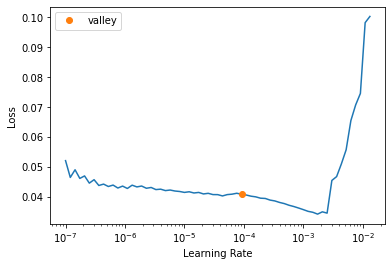

In [33]:
learn.unfreeze()
learn.lr_find()

In [34]:
tobacco_clas = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
            get_x=get_features, 
            get_y=get_labels)

dl = tobacco_clas.dataloaders(df_train_val, bs=64)
dl.show_batch(max_n=2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxup u ) ö tn t ; ( fi a « o ri o o u xxmaj lj o ü - ] ■ xxup vd ( ji rl xxunk < u o p cj o i m i y 4j o ■ h f i xxmaj hl < ; < h o 4 > si tu o m xxup xxunk , | > xxunk fl tj * xxmaj xxunk o o n fi xxup xxunk ri tj o fl to ö » * * o to * fi « 1 < l > -h > « 3 e > p xxunk rh ft 4j xxmaj fh m | > o / ■ > 0 xxunk rj 0 < 9 , ri xxup hj < i > o xxup cd < il it . 5 xxunk xxup cj xxmaj pi fh j • tn d xxmaj vi * ■ .",NextPage
1,"xxbos xxunk xxmaj federal xxmaj register / xxmaj vol . 45 . xxmaj no . 7 l xxmaj xxunk . xxmaj xxunk 10 , xxunk / xxmaj xxunk xxmaj tb 1 ml xxunk 1 xxmaj xxunk xxunk - xxunk xxup xxunk ) , « ! ( xxunk xxmaj xxunk » sf xxmaj xxunk xxunk xxmaj xxunk l c ta xxmaj xxunk # tm xxup mh « far .. . ti 10 xxmaj xxunk xxunk » - « or … … .. ■ . xxrep 3 - * * "" 3 w * . » xxunk . 1 0 « xxmaj xxunk . xxrep 4 - - xxmaj xxunk xxunk xxmaj mt * … … .. » 0 « xxunk … xxunk : f 01 ■ mt xxmaj xxunk i 04 xxunk - - xxmaj xxunk xxmaj al ! » * 5 04 xxunk xxup ta » xxunk xxrep 3 -",NextPage


In [35]:
learn_c = text_classifier_learner(dl, AWD_LSTM, drop_mult=0.5,metrics=[error_rate, accuracy, Perplexity()]).to_fp16()

In [36]:
learn_c.show_results()

,text,category,category_
0,"xxbos i xxunk xxunk xxup herbert xxup m. xxup wachtell xxup theodore xxup gewertz xxup bernard xxup w. xxup nussbaum xxup richard xxup o. xxup xxunk xxup douglas xxup s. xxup xxunk xxup steven xxup m * xxup bar xxup na xxup chaim xxup j * xxup fortgang xxup peter xxup c * xxup canellos xxup michael xxup w * xxunk xxup allan xxup a. xxup martin xxup barry xxup a. xxunk xxup lawrence xxup b- xxup xxunk xxup robert xxup b. xxup mazur xxup paul xxunk , xxmaj jfl . xxup peter xxup c. xxup hein xxup harold 5 . xxup xxunk xxup david xxup m * xxup einhorn xxup xxunk xxup b , xxup forrest xxup meyer xxup g. xxup koplow xxup theodore xxup n * xxup xxunk xxup edward xxup d * xxup xxunk xxup richard xxup d. xxunk xxup daniel xxup a. xxup neff xxup eric",FirstPage,NextPage
1,"xxbos xxunk xxmaj sudol , xxmaj marius 129 - 68 - 8626 3 . xxmaj xxunk , xxup xxunk . , xxmaj harvey , xxup r. , xxmaj xxunk , xxup xxunk . , xxmaj xxunk , xxup k. , xxmaj xxunk , xxup t. , xxmaj toyoshima , xxup t. , xxmaj smith , xxup xxunk . ( 1988 ) xxup xxunk . xxup j. xxunk - xxunk 4 . xxmaj xxunk , xxup s.a . ( 1983 ) xxmaj nature xxunk - xxunk 6 . xxmaj xxunk , xxup j. , xxmaj neil , xxup xxunk . , and xxmaj vogt , xxup xxunk . ( 1981 ) xxmaj xxunk . xxmaj natl . xxmaj acad . xxmaj sei . xxup usa xxunk - xxunk 6 . xxmaj hanafusa , xxup h. ( 1986 ) xxmaj in xxmaj oncogenes and xxmaj growth xxmaj control , xxunk . xxup",NextPage,FirstPage
2,"xxbos j • xxunk rightfax xxmaj server to : ronald xxmaj xxunk 5 / 98 xxunk : xxup page 3 / 4 # xxunk xxmaj wachtell . xxmaj lipton , xxmaj rosen & xxmaj katz xxmaj martin xxunk xxup herbert xxup m , xxup wachtell xxmaj theodore xxunk xxup xxunk xxup w. xxup nu xxrep 3 ö xxup aum xxup richard □ . xxup xxunk xxunk xxup s. xxunk xxunk xxup m * xxup xxunk xxup charles xxup t. xxunk , xxup chaim xxup j » xxunk peter c. xxunk * xxup michael xxup w. xxup schwarte xxup allan xxup a. xxup martin xxup harry xxmaj ah xxunk xxup lawrence xxmaj el . xxunk xxup robert xxup b- xxup mazur xxup pall xxunk * xxup jr . xxup xxunk xxup c. xxup hein xxup harold xxup s. xxunk xxup david xxmaj mr xxup einhorn xxup kenneth « . xxup forrest",FirstPage,NextPage
3,"xxbos xxup the am ; xxup can xxup tobacco xxup company xxup domestic xxup returned xxup goods xxup analysis xxup january 1989 xxup thru xxup september 1990 ( xxunk 's ) xxup xxunk xxup return xxup xxunk t xxunk 45 h h m « xxunk xxup xxunk xxunk « ■ mm , sm xxunk ■ - - ■ xxunk xxup mt xxup xxunk xxunk : ' xxunk xxunk xxrep 3 t xxunk xxunk : xxunk « : xxunk xxrep 3 0 2 : xxunk xxrep 3 0 xxunk xxup xxunk xxup jan 196 « ( $ xxunk ) $ xxunk ( $ xxunk ) * xxunk xxunk % ( * xxunk ) ( 626 ) * 1 ( * « 6 ) $ 64 $ 8 * 46 « 17 « xxup feb ( $ xxunk ) $ xxunk ( xxunk ) * xxunk £ xxunk % ( $ xxunk",NextPage,NextPage
4,"xxbos ’ "" from xxunk xxunk xxunk m xxup xxunk xxup theodore xxup xxunk > xxunk w xxup nu s xxmaj xxunk xxup au h xxup him / xxmaj xxunk xxmaj cr « xxunk xxunk s. xxunk xxunk xxmaj mi xxup xxunk * xxup charles xxmaj ti xxup xxunk * xxup xxunk j xxup fortgang xxunk xxup c. xxup xxunk xxunk xxup w. xxup schwarte allan a » xxmaj martin « xxunk xxunk « xxunk 9 * xxup xxunk xxup xxunk 9 * xxup xxunk « aul xxup xxunk . xxup jr » xxunk fit xxup xxunk xxup xxunk xxup s < xxunk xxup david xxup m. xxunk xxup xxunk xxup d. xxunk xxup xxunk xxup g. « xxunk xxup theodore xxup w. xxunk * xxup xxunk o. xxunk xxup richard xxup o- xxunk xxunk xxmaj ar « cf « xxunk xxup m , xxup roth xxup xxunk xxup a",FirstPage,FirstPage
5,"xxbos # xxmaj wachtell , xxmaj lipton , xxmaj rosen & xxmaj katz xxup martin xxup lipton xxup herbert xxup m. xxup wachtell xxup theodore xxup xxunk * xxup xxunk xxup w- xxup nussbaum xxup richard xxup o- xxup katcher xxup douglas 5- xxup xxunk xxup steven xxup m * xxup barna xxup chaim xxup j- xxup fortgang xxup peter xxup c. xxup canellos xxup michael xxup w * xxunk xxup allan xxup a. xxup martin xxup barry xxup a. xxup bryer xxup lawrence ß . xxup peoowitz 

SuggestedLRs(valley=0.002511886414140463)

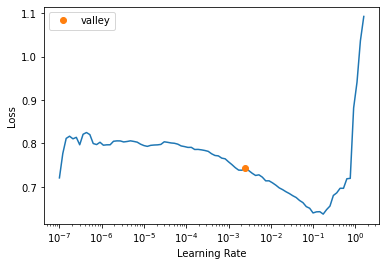

In [37]:
learn_c.freeze()
learn_c.lr_find()

In [38]:
learn_c.fit_one_cycle(10, 2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.728843,0.569483,0.300971,0.699029,1.767352,00:03
1,0.620995,0.499038,0.247573,0.752427,1.647136,00:03
2,0.564362,0.409823,0.189320,0.810680,1.506552,00:03
3,0.540404,0.422535,0.140777,0.859223,1.525824,00:03
4,0.504441,0.334826,0.150485,0.849515,1.397697,00:03
5,0.463826,0.378937,0.145631,0.854369,1.460730,00:03
6,0.434426,0.416442,0.150485,0.849515,1.516556,00:03
7,0.407876,0.390463,0.135922,0.864078,1.477665,00:03
8,0.383734,0.376493,0.131068,0.868932,1.457165,00:03
9,0.362975,0.375292,0.126214,0.873786,1.455416,00:03


In [39]:
learn_c.save("clf_dl")

Path('models/clf_dl.pth')

In [40]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.293301,0.394086,0.145631,0.854369,1.483029,00:04
1,0.326836,0.662413,0.174757,0.825243,1.939467,00:04
2,0.351919,0.393761,0.121359,0.878641,1.482545,00:04
3,0.342213,0.399375,0.106796,0.893204,1.490893,00:04
4,0.331649,0.407633,0.126214,0.873786,1.503255,00:04
5,0.305591,0.386628,0.106796,0.893204,1.472009,00:04
6,0.277312,0.393748,0.106796,0.893204,1.482527,00:04
7,0.250055,0.416149,0.106796,0.893204,1.516112,00:04
8,0.226511,0.426741,0.106796,0.893204,1.532255,00:04
9,0.205768,0.412753,0.116505,0.883495,1.510972,00:04


In [41]:
learn_c.save("clf_dl")

Path('models/clf_dl.pth')

In [42]:
learn_c.unfreeze()
learn_c.fit_one_cycle(10, slice(1e-2/10/(2.6**4),1e-2/10))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.129655,0.420099,0.111650,0.888350,1.522113,00:07
1,0.141547,0.404803,0.101942,0.898058,1.499006,00:07
2,0.139776,0.413209,0.106796,0.893204,1.511661,00:07
3,0.133142,0.397670,0.097087,0.902913,1.488353,00:07
4,0.125046,0.422220,0.121359,0.878641,1.525344,00:07
5,0.121993,0.423324,0.087379,0.912621,1.527028,00:07
6,0.115945,0.406020,0.106796,0.893204,1.500833,00:08
7,0.111463,0.415258,0.101942,0.898058,1.514761,00:08
8,0.107124,0.413769,0.101942,0.898058,1.512507,00:07
9,0.100001,0.423001,0.101942,0.898058,1.526536,00:07


In [43]:
learn_c.save("clf_dl")

Path('models/clf_dl.pth')